<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Como_detectar_eventos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo detectar eventos en series temporales

Jose Luis López Elvira ([enlace a más recursos en GitHub](https://github.com/joselvira/BiomecanicaPython))

Última modificación 28/05/2025

Lo primero, tenemos que tener claro qué es un evento. Podemos considerar como eventos instantes característicos y distinguibles de las señales temporales. Por ejemplo, en señales cíclicas que se van repitiendo en el tiempo, los máximos y mínimos locales son instantes característicos que podemos usar para dividir cada ciclo. Pero también es un evento el instante en el que se inicia el movimiento en un salto vertical, o cuando la señal supera o desciende un umbral determinado.

Vamos a ver ejemplos de cada uno de los casos que podemos encontrar.

Empezamos importando librerías básicas.

In [1]:
import numpy as np # tipo de datos Numpy
import pandas as pd # tipo de datos Pandas
import xarray as xr # tipo de datos xarray

import matplotlib.pyplot as plt # librería básica para representar gráficas
import seaborn as sns # gráficos avanzados

Para empezar por un ejemplo sencillo, creamos una onda sinusoidal que puede representar a cualquier variable de un movimiento cíclico continuo. Para hacerlo más interesante (y real), haremos que todas las repeticiones no sean exactamente iguales introduciendo algunas diferencias aleatorias.

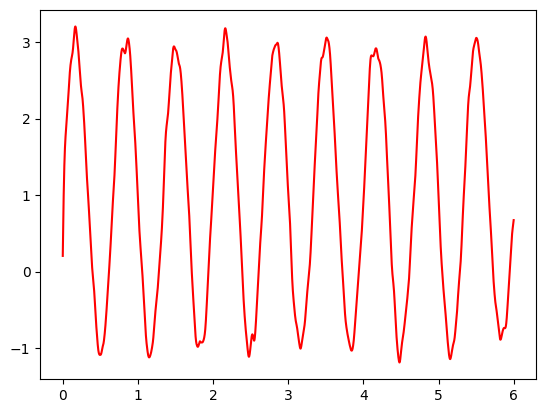

In [11]:
from scipy.signal import butter, filtfilt

np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad

#calcula array tiempo
duracion = 6.0 #duración del registro en segundos
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)


of=-1 #offset vertical
a=2 #ampitud
f=1.5 #frecuencia
af=0 #ángulo de fase, ángulo al inicio del tiempo

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))

#Crea un ruido aleatorio controlado y lo filtra
a_err = a*0.5
pasadas = 2.0 #nº de pasadas del filtro adelante y atrás
orden = 2
fc_err = 10
Cf = (2**(1/pasadas)-1)**(1/(2*orden)) #correction factor. Para 2nd order = 0.802
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(orden, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))


#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
var = señal + ruido

fig, ax = plt.subplots()
plt.plot(t, var, '-', color= 'r')
plt.show()

## Detectar máximos y mínimos

Tendremos que buscar los instantes en los que se producen esos valores máximos y guardarlos en una variable.

Podemos utilizar la función *find_peaks* de la librería *Scipy*, que devuelve los índices de los lugares en los que se producen los máximos locales de la señal.

[ 167  794  867 1479 1825 1843 2162 2523 2857 3510 4108 4167 4827 5503
 5874]


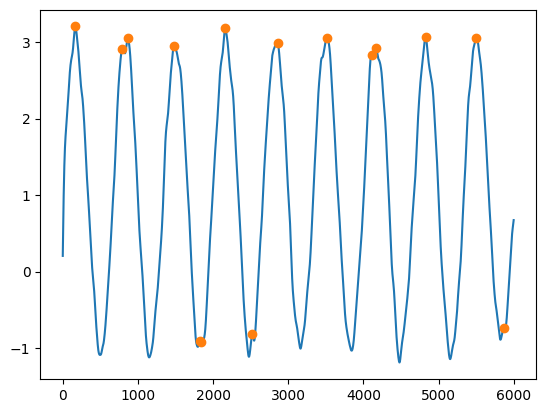

In [12]:
from scipy.signal import find_peaks

maxs, properties = find_peaks(var)
print(maxs)

#Gráfica con la señal y los puntos máximos encontrados.
fig, ax = plt.subplots()
plt.plot(var)
plt.plot(maxs, var[maxs], 'o')
plt.show()

Fíjate en que en algunas repeticiones encuentra máximos locales muy próximos unos a otros dentro de la misma repetición. Incluso puede encontrar un máximo en un lugar cercano a un valle, porque se produce algún repunte en la señal.
Esto es un problema si lo que necesitamos es encontrar instantes característicos para dividir la señal en repeticiones, que deberían tener una dureción similar.

Estos problemas son frecuentes en señales reales, por eso la función *find_peaks* tiene algunos parámetros para refinar la búsqueda, como *distance*, que marca una separación mínima entre máximos, *threshold* que establece un umbral por debajo del cual no busca, etc. El ejemplo anterior se poddría solucionar por ejemplo ajustando la función de esta forma.

[ 167  867 1479 2162 2857 3510 4167 4827 5503]


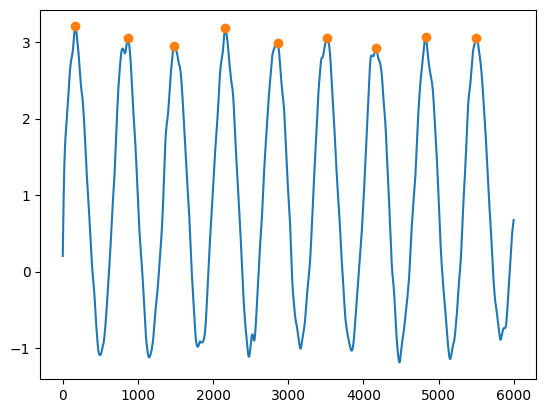

In [13]:
maxs, properties = find_peaks(var, distance=500)
print(maxs)

#Gráfica con la señal y los puntos máximos encontrados.
fig, ax = plt.subplots()
plt.plot(var)
plt.plot(maxs, var[maxs], 'o')
plt.show()

Pero para tener más variedad de funciones a utilizar, vamos a probar otra la librería, una creada por Marcos Duarte que se llama *Detecta*, que tiene funciones muy flexibles no solo para encontrar los máximos y mínimos locales, sino también para detectar cuándo se supera un umbral, entre otras. Funciona perfectamente para esas tareas.

Para poder utilizar esta librería es necesario instarla porque no viene por defecto en el entorno de *Colab*, se hace fácilmente con el siguiente comando.

In [4]:
#Instala la librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_peaks

Probamos la función con nuestra variable. Fíjate en que tiene incluso una opción para visualizar gráficamente la localización de los eventos que encuentra (activando el parámetro show).

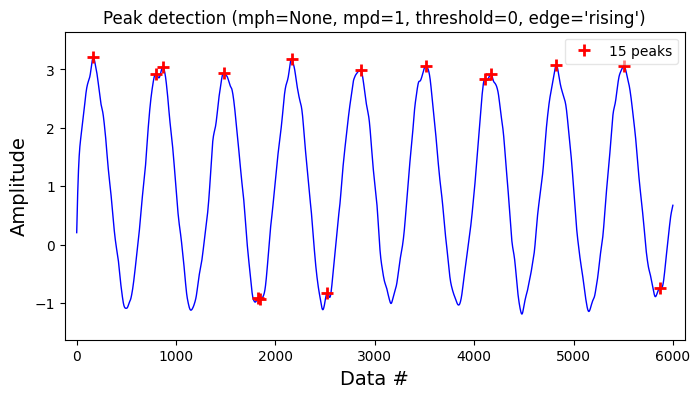

In [14]:
maxs = detect_peaks(var, show=True)

Para evitar los falsos positivos que se ven, vamos a perfeccionar la búsqueda introduciendo algunas restricciones. Por ejemplo, cabe esperar que haya un pico cada repetición y no antes, por lo que podemos fijar una distancia mínima desde que encuentra un pico de un número de datos equivalente a la mitad de lo que dura una repetición. En este ejemplo la frecuencia de base de la señal son 1.5 Hz, y la frecuencia de registro son 1000 Hz, por lo que cada ciclo o repetición tiene 1000/1.5 datos, es decir, 666.66 datos. Como la duración de cada ciclo no es exacta, pondremos un valor un poco menor para evitar perder máximos.

Con la instrucción *help(detect_peaks)* se pueden ver las opciones de la función.

In [6]:
help(detect_peaks)

Help on function detect_peaks in module detecta.detect_peaks:

detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False, show=False, ax=None, title=True)
    Detect peaks in data based on their amplitude and other features.
    
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a 

Nos interesa modificar el parámetro *mpd*, que regula el mínimo de datos que deben pasar de un pico a otro. Se puede jugar con los valores hasta encontrar una afinación que funcione para lo que queremos hacer. Como vimos anteriormente, en este caso cada ciclo son unos 666 datos, podríamos poner en torno a la mitad de ese valor. En este caso, poniendo *mpd=400* funciona bien para evitar los dobles picos y para evitar también los picos de los valles. Para esto último también podríamos haber fijado un umbral o altura mínima de búsqueda de máximos de, por ejemplo, 2 unidades (en el parámetro *mph* de la función), pero como en este ejemplo funciona bien así, lo dejamos.

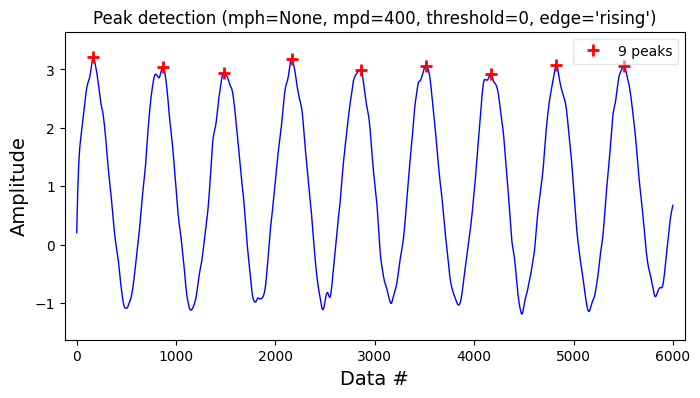

In [7]:
maxs = detect_peaks(var, mpd=400, show=True)

Si quisiéramos detectar los valles, simplemente se debe incluir la instrucción *valley=True* en la función, que lo que hace internamente es invertir el signo de la señal para que los mínimos pasen a ser máximos durante la búsqueda.

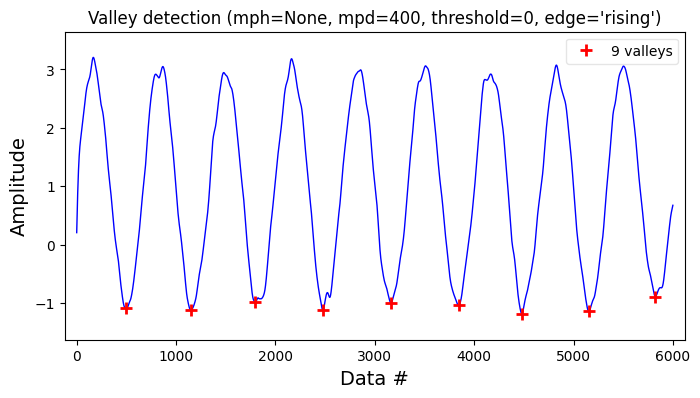

In [15]:
mins = detect_peaks(var, mpd=400, valley=True, show=True)

Para más información sobre los ajustes finos de la función, consulta en la web de la librería [*Detecta*](https://pypi.org/project/detecta/).

Lo que tenemos es un listado de los eventos de máximos y mínimos locales, que posteriormente podríamos utilizar para separar en repeticiones, asumiento que cada ciclo empieza y termina con cada máximo o mínimo.

Podemos ver los instantes que ha detectado.

In [17]:
print(maxs)
print(mins)

[ 167  794  867 1479 1825 1843 2162 2523 2857 3510 4108 4167 4827 5503
 5874]
[ 495 1149 1796 2477 3163 3843 4480 5153 5823]


## Detectar cortes por un umbral



## Detectar inicios mediante una subida o bajada de la señal

